## Подготовка данных

В работе представлены данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы.

Цель проекта: выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании интернет-магазина «Стримчик».

Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

server_path = '/datasets/games.csv' 
local_path = 'games.csv' 

#использую конструкцию try-except удобства запуска локально и через сервер практикума
try:  
    data = pd.read_csv(server_path) 
except: 
    data = pd.read_csv(local_path)

In [46]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [47]:
# получение общей информации о данных в таблице df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Заменим названия столбцов, приведём их к нижнему регистру.

In [48]:
# перечень названий столбцов таблицы data
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [49]:
# переименование столбцов
data = data.rename(columns={'Name':'name','Platform':'platform','Year_of_Release':'year_of_release', 'Genre':'genre', 
                            'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales','Other_sales':'other_sales', 
                            'Critic_Score':'critic_score', 'User_Score':'user_score', 'Rating':'rating'})
# проверка результата
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Для работы с датой и временем существует особый тип данных— datetime. Чтобы перевести строки столбца 'year_of_release' в дату, используется метод to_datetime().

In [50]:
# перевод из строки в дату
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y')
# получение года из даты
data['year'] = pd.DatetimeIndex(data['year_of_release']).year

В столбце 'user_score' присутствуют значения 'tbd'. Данная аббревиатура от английского "To Be Determined" означает "будет определено". Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков. Поэтому заменим значение 'tbd' на nan, затем переведем тип данных столбца 'user_score' к float для определения корреляция и стат-тестов в следующих шагах.

In [51]:
# перевод из строки к типу данных float
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
data['user_score'] = data['user_score'].astype(float)

In [52]:
# определение количества пропущенных значений
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
year                269
dtype: int64

В столбцах 'name', 'year_of_release' небольшое количество пропущенных значений (менее 2%), поэтому следует удалить пропущенные значения в данных столбцах. В столбцах 'critic_score', 'user_score', 'rating' достаточно большое количество пропусков, поэтому следует оставить данные без изменений.

In [53]:
# удаление пропущенных значений
data.dropna(subset = ['name','year_of_release'], inplace = True)

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [54]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

**Вывод**

В ходе подготовительных операций в проекте были переименованы столбцы, заменены типы данных для столбцов 'year_of_release', 'user_score', удалены нулевые строки столбцов 'name', 'year_of_release', добавлен столбец 'total_sales', который демонстрирует суммарные продажи игр во всех регионах.

## Исследовательский анализа данных

### Определение актуального периода

Установим частоту выпуска игр в разные годы, для этого посторим гистограмму распределения игр по годам.

In [55]:
# определение количества корзин с помощью формулы Стерджесса
int(np.ceil(1 + 3.32 * np.log(data.shape[0])))

34

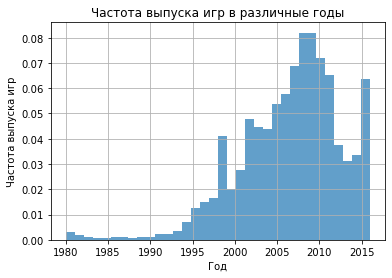

In [56]:
# отображение частоты выпуска игр в различные годы
data['year'].plot(kind='hist', bins=34, grid=True, alpha=0.7, density=True)
plt.xlabel('Год')
plt.ylabel('Частота выпуска игр')
plt.title('Частота выпуска игр в различные годы');

В период с 1980-2002 год количество выпущенных игр было незначитальным по сравнению с периодом 2002-2015 года, поэтому следует удалить строки игр с годом выпуска 1980-2002 год. 

In [57]:
# получение среза данных для игр с годом выпуска от 2002 года
data = data.query('year_of_release > 2002')

### Определение прибыльных платформ

Выясним как менялись продажи по платформам.

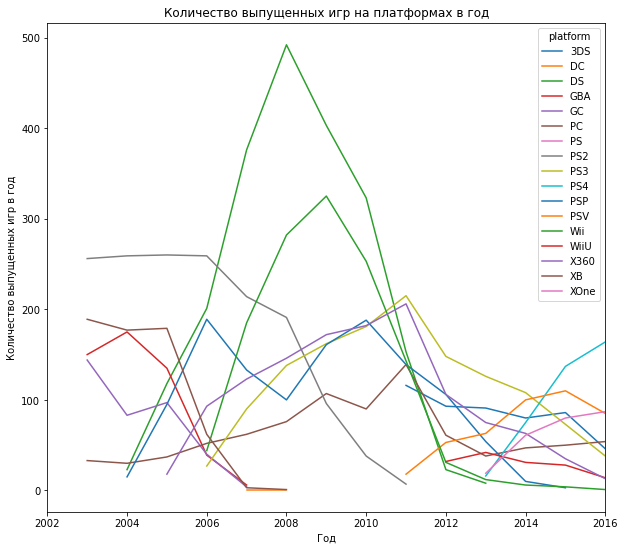

In [58]:
# формирование сводной таблицы для получения количества выпущенных игр на платформах в год
sales_per_year = data.pivot_table(index = ['year'], columns='platform', values='name', aggfunc='count')
# построение графика по датафрейму sales_per_year
sales_per_year.plot(figsize=(10,9))
plt.xlim(2002,2016)
plt.xlabel('Год')
plt.ylabel('Количество выпущенных игр в год')
plt.title('Количество выпущенных игр на платформах в год');

В период с 2002 по 2012 год количество выпущенных игр на платформах в год значительно больше, чем в период с 2012 по 2016 год. Скорее всего выпуск игр меньшего количества связан с тем, что компании делают ставки на качество игр, тратя больше времени на их разработку.

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

In [85]:
# обозначение минимальных значимых продаж в миллионах 
min_sales = 5
# формирование сводной таблицы для получения суммы общих продаж, сгруппированных по платформе и году
report = data.groupby(['platform', 'year_of_release']).agg({'total_sales': 'sum'}).reset_index().\
query('total_sales > @min_sales')
#  сортировки таблицы по указанному столбцу 'total_sales'
report.sort_values(by = 'total_sales', ascending = False).head(10)

,platform,year_of_release,total_sales
44,PS2,2004-01-01,211.81
88,Wii,2009-01-01,206.97
43,PS2,2003-01-01,184.31
87,Wii,2008-01-01,171.32
106,X360,2010-01-01,170.03
45,PS2,2005-01-01,160.66
57,PS3,2011-01-01,156.78
86,Wii,2007-01-01,152.77
11,DS,2007-01-01,146.94
12,DS,2008-01-01,145.31


Наибольшее число проданных копий в год на платформах PS2, Wii, X360, PS, PS2.

In [60]:
# переименование колонок сводной таблицы
report.columns = ['platform', 'year_of_release','sum_sales']
# подсчет среднего срока существования платформы
report.groupby('platform').agg({'sum_sales':  'count'}).reset_index().mean()

sum_sales    6.733333
dtype: float64

Итак, 7 лет - среднее время жизни платформ, но для определения закономерностей успешности игр необходимо пользоваться более свежими данными, так как компьютерные игры - это бурно развивающаяся отрасль, где пользователи с каждым годом становятся более требовательными. Графика игры должна становиться всё более притягательной для глаз, избыточной, создавать качественные пространства. Поэтому для определения связей популярности игр среди пользователей следует брать более короткий период в 3 года. Получим срез данных для игр с годом выпуска с 2014 по 2016 год включительно.

In [61]:
# получение среза данных для игр за актуальный период
actual_data = data.query('year_of_release > 2013')

Установим какие платформы были активны за этот период.

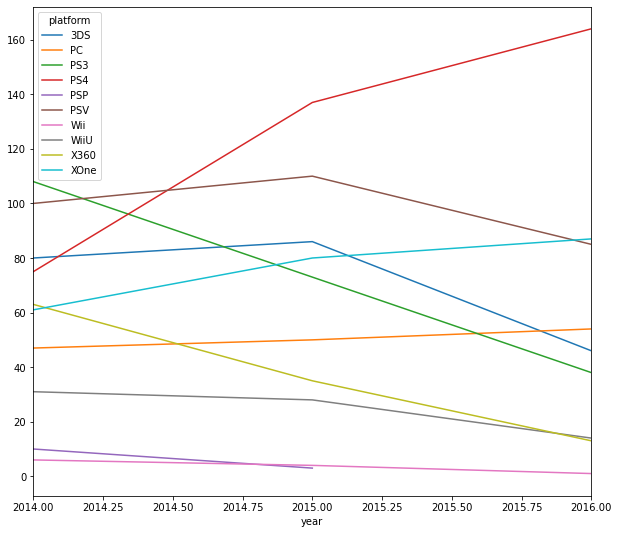

In [62]:
# формирование сводной таблицы для получения количества выпущенных игр на платформах в год за актульный период
sales_per_year_actual = actual_data.pivot_table(index = 'year', columns='platform', values='name', aggfunc='count')
# построение графика по датафрейму sales_per_year_actual
sales_per_year_actual.plot(figsize=(10,9))
plt.xlim(2014,2016);

Потенциально прибыльные платформы в выпуске игр за актуальный период: PS4, XOne, PC.

In [63]:
actual_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014-01-01,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015-01-01,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016-01-01,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


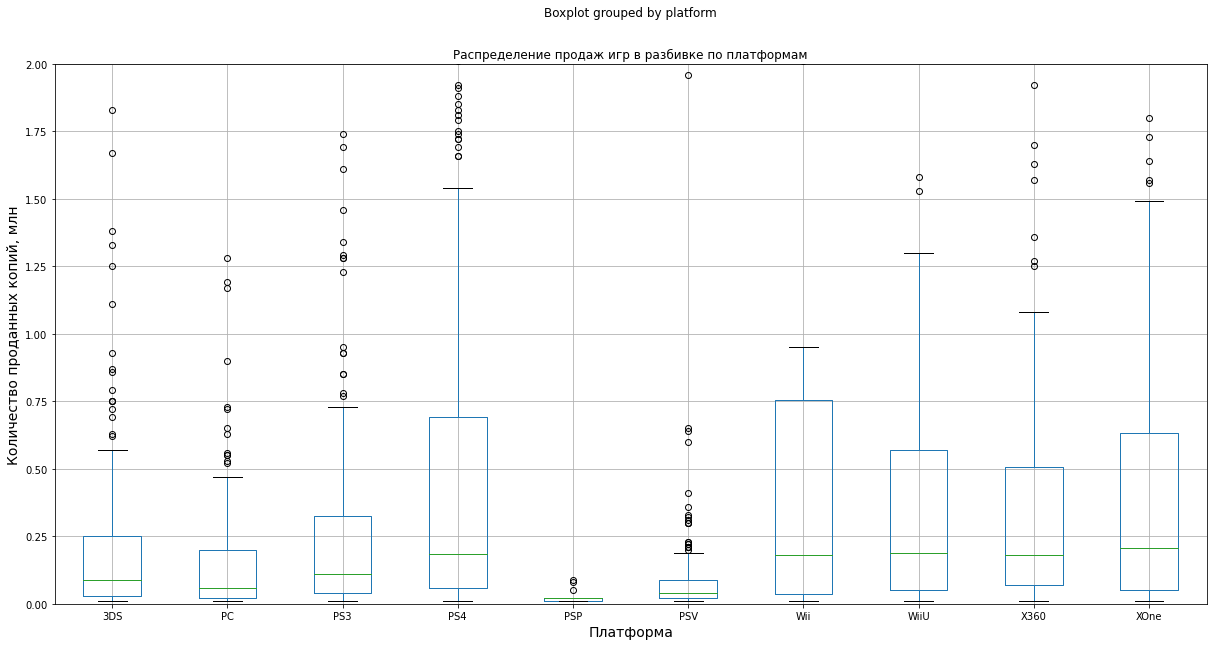

In [64]:
# oтображение диаграммы ящик с усами по глобальным продажам игр в разбивке по платформам за актуальный период 
actual_data.boxplot(column='total_sales', by='platform', figsize=(20,10))
plt.ylim(0,2)
plt.xlabel('Платформа', size=14)
plt.ylabel('Количество проданных копий, млн', size=14)
plt.title('Распределение продаж игр в разбивке по платформам');

Диаграмма "ящик с усами" показывает распределение данных по количеству проданных копий. Вертикальные линии под названием "усы" указывают на отклонение за пределами верхнего и нижнего квартилей, и любая точка за пределами этих линий (усов) считается выбросом. Выбросы - значения, которые сильно отличаются от большинства значений в наборе данных. Наличие большого количества выбросов и низкая плотность сгруппированых данных демонстрируют изменчивый характер продаж игр по платформ в регионах в течение всего актуального периода. 
    
Наиболее устойчивые платформы по продажам игр, имеющие самые высокие значения медианных продаж: PS4, Wii, WiiU, XOne, X360.

### Корреляция между отзывами и продажами

Для каждой популярной платформы оценим как отзывы пользователей и критиков влияют на продажи. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [65]:
# создание отдельного списка платформ с самыми высокими медианными продажами
top_platform = ['PS4', 'XOne', 'PC'] 
# создание цикла для расчета корреляции для элементов в списке
for item in top_platform:
    print(f'{item}')
    display(actual_data.query('platform == @item')[['critic_score', 'user_score', 'total_sales']].corr())   
    print()

PS4


,critic_score,user_score,total_sales
critic_score,1.000000,0.546434,0.402661
user_score,0.546434,1.000000,-0.040132
total_sales,0.402661,-0.040132,1.000000



XOne


,critic_score,user_score,total_sales
critic_score,1.000000,0.440977,0.428677
user_score,0.440977,1.000000,-0.070384
total_sales,0.428677,-0.070384,1.000000



PC


,critic_score,user_score,total_sales
critic_score,1.000000,0.466099,0.174634
user_score,0.466099,1.000000,-0.071597
total_sales,0.174634,-0.071597,1.000000


Коэффициент корреляции примерно для каждой платформы в 0.4 для данных столбца 'total_sales' и 'critic_score' говорит о наличии связи, однако не слишком сильной. Выходит, высокая оценка критиков сопровождается увеличением продаж, но так бывает не всегда. Корреляция для 'total_sales' и 'user_score' близка к нулю, значит, при изменении величины 'user_score' другая 'total_sales' остаётся прежней.

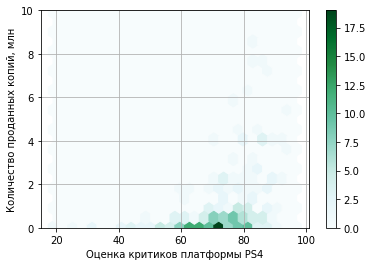

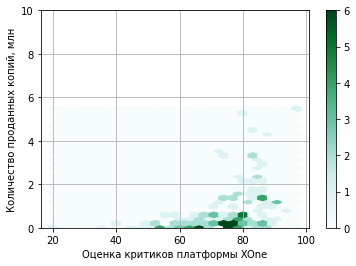

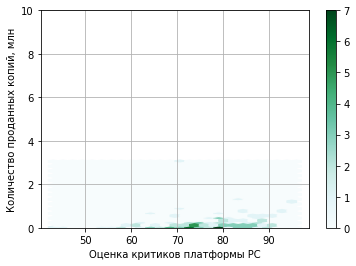

In [66]:
# создание отдельного списка платформ с самыми высокими медианными продажами
top_platform = ['PS4', 'XOne', 'PC'] 
# создание цикла для построения диаграмм рассеяния 'critic_score' и 'total_sales' для популярных платформ
for item in top_platform:
    actual_data.query('platform == @item').plot(x='critic_score', y='total_sales',  kind='hexbin', 
                                                gridsize=25, grid=True, sharex=False)
    plt.ylim(0,10)
    plt.xlabel(f'Оценка критиков платформы {item}')
    plt.ylabel('Количество проданных копий, млн')
    plt.show()

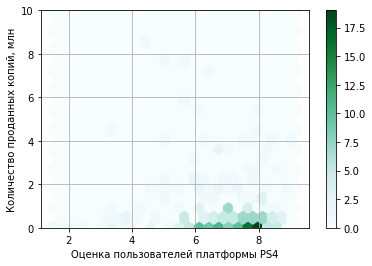

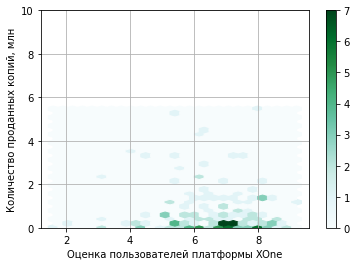

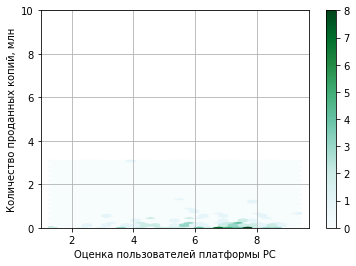

In [67]:
# создание отдельного списка платформ с самыми высокими медианными продажами
top_platform = ['PS4', 'XOne', 'PC'] 
# создание цикла для построения диаграмм рассеяния 'user_score' и 'total_sales' для популярных платформ
for item in top_platform:
    actual_data.query('platform == @item').plot(x='user_score', y='total_sales',  kind='hexbin', 
                                                gridsize=25, grid=True, sharex=False)
    plt.ylim(0,10)
    plt.xlabel(f'Оценка пользователей платформы {item}')
    plt.ylabel('Количество проданных копий, млн')
    plt.show()

На графиках по каждой популярной платформе можно увидеть слабую взаимосвязь между величинами 'critic_score' и 'total_sales', а также отстутие взаимосвязи между величинами 'user_score' и 'total_sales'.

### Определение прибыльных жанров

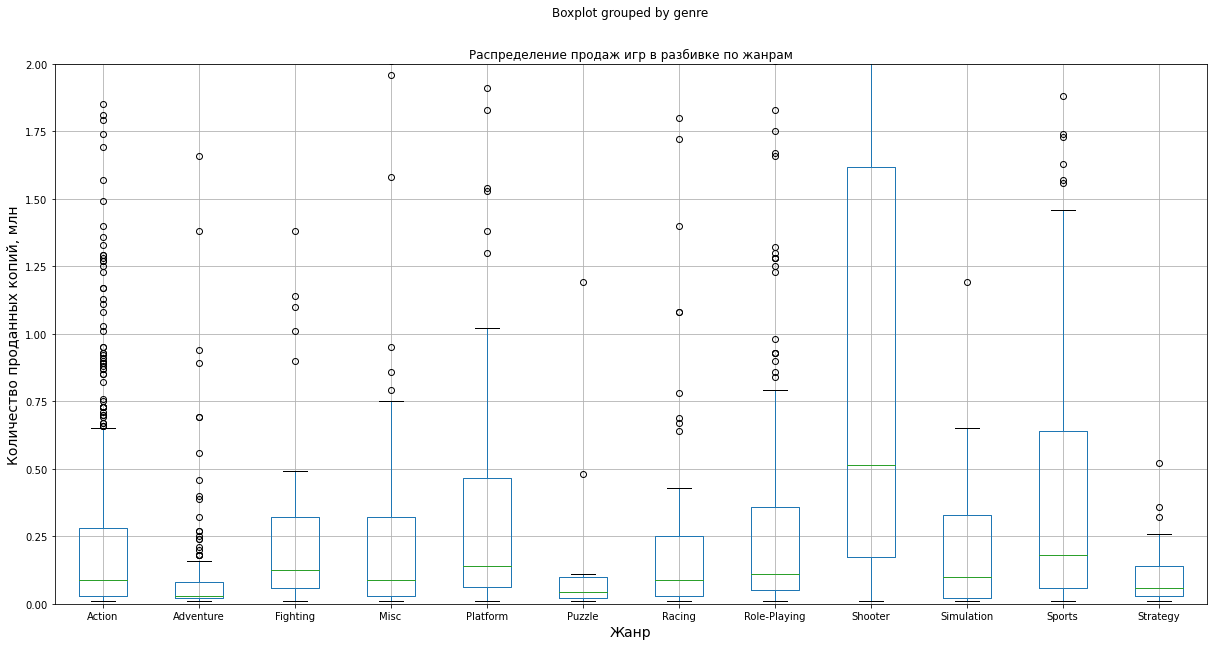

In [68]:
# oтображение диаграммы ящик с усами по глобальным продажам игр в разбивке по жанрам
actual_data.boxplot(column='total_sales', by='genre', figsize=(20,10))
plt.ylim(0,2)
plt.xlabel('Жанр', size=14)
plt.ylabel('Количество проданных копий, млн', size=14)
plt.title('Распределение продаж игр в разбивке по жанрам');

Анализируя распределения общих продажи по жанрам можно сделать вывод, продажи зависят от жанра выпускаемой игры. Самые высокие медианные продажи у игр жанра shooter, sports, fighting, racing, role-playing. Самые низкие продажи у игр жанра adventure,  puzzle, stategy.

**Вывод**

Согласно графику распределения количества выпущенных игр в год по каждой платформе, диаграмме глобальных продаж игр в разбивке по платформам и жанрам, сводной таблице max_sales, показывающей список платформ с наибольшими продажами за актуальный период, в следующем 2017 году следует выпустить игру на платформе PS4 в жанре Shooter.

## Составление портрета пользователя каждого региона

### Самые популярные платформы

Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5).

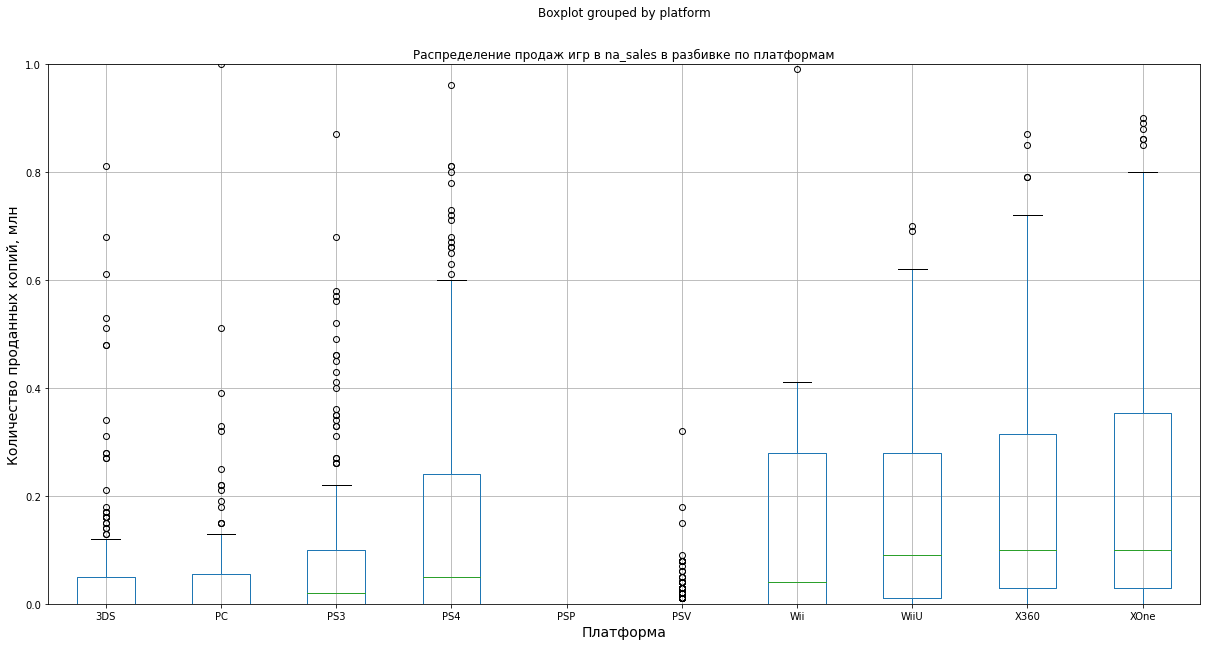

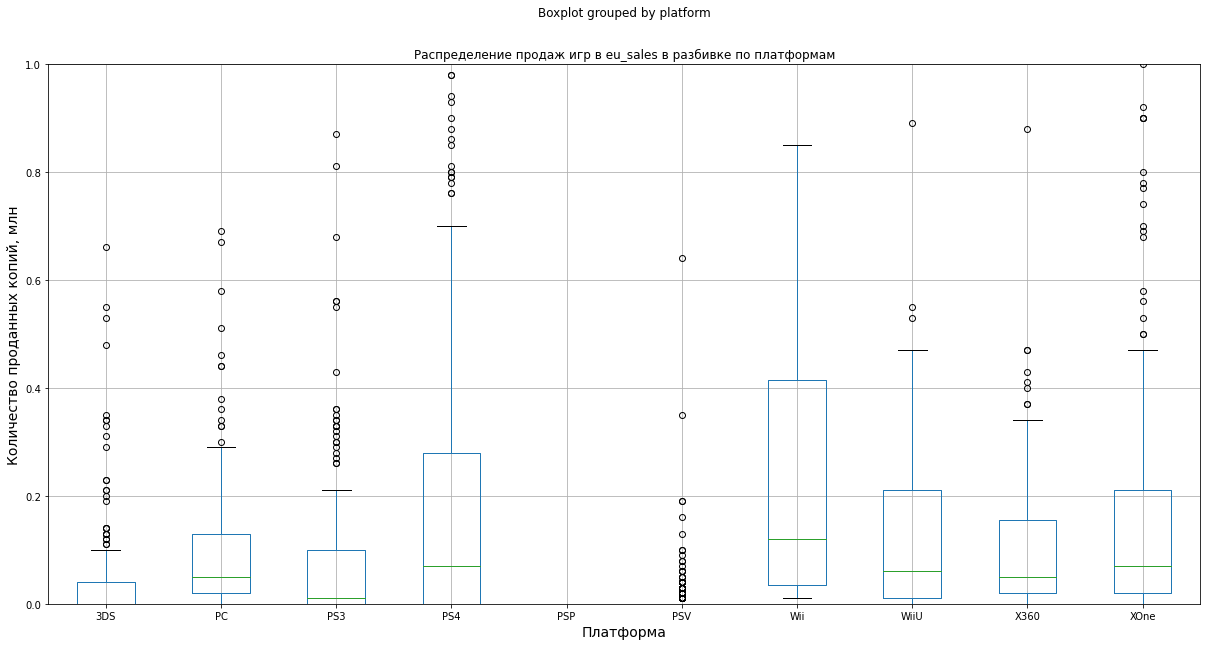

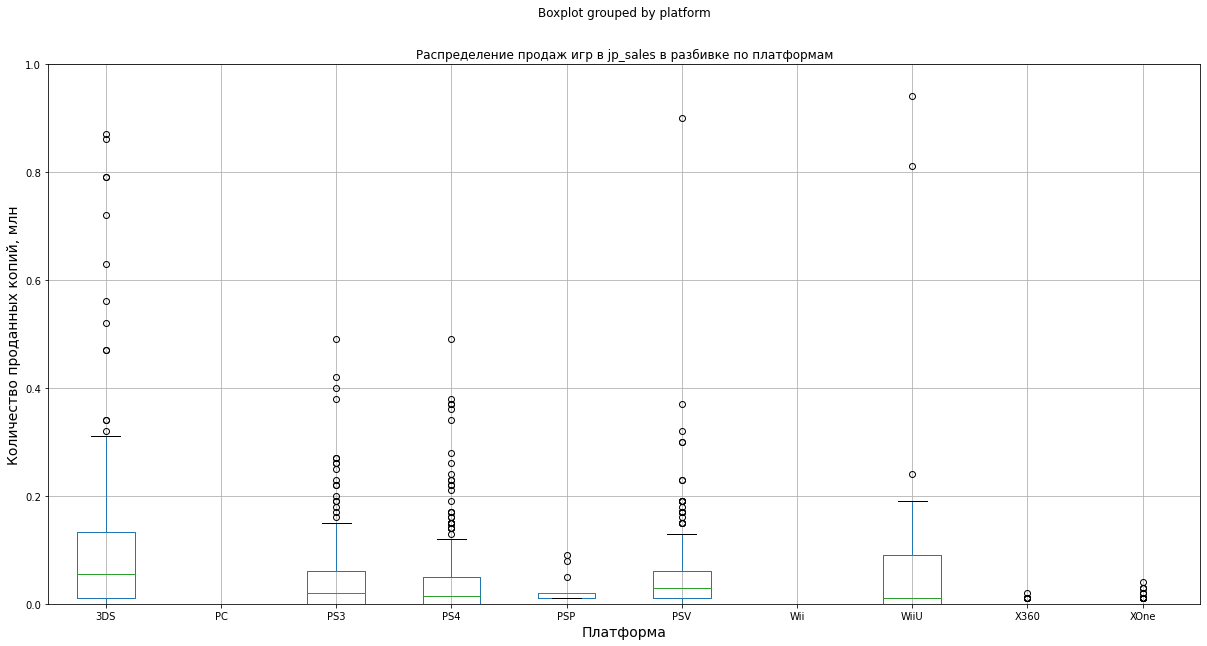

In [69]:
# создание списка регионов
columns = ['na_sales', 'eu_sales', 'jp_sales']
# oтображение диаграммы ящик с усами по глобальным продажам игр в Северной Америке, Европе, Японии в разбивке по платформам
for item in columns:
    actual_data.boxplot(column=item, by='platform', figsize=(20,10))
    plt.ylim(0,1)
    plt.xlabel('Платформа', size=14)
    plt.ylabel('Количество проданных копий, млн', size=14)
    plt.title(f'Распределение продаж игр в {item} в разбивке по платформам');

In [70]:
# формирование сводной таблицы для получения списка платформ с наибольшими продажами 
#за актуальный период в Северной Америке 
sales_platform_na = actual_data.pivot_table(index = 'platform', values='na_sales', aggfunc='sum').\
reset_index().sort_values(by = 'na_sales', ascending = False)
sales_platform_na

,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05
7,WiiU,19.36
1,PC,7.23
5,PSV,2.52
6,Wii,2.08
4,PSP,0.00


In [71]:
# построение круговой диаграммы
#plt.pie(sales_platform_na['na_sales'], labels=sales_platform_na['platform'], autopct="%1.1f%%", shadow=True, radius=2);
#plt.suptitle('Доли продаж в Северной Америке', y=1.3);
#plt.legend(loc='upper left', bbox_to_anchor=(1.5, 1.5))

fig = px.bar(sales_platform_na, x="platform", y="na_sales", title="Продажи в Северной Америке", 
             labels={'na_sales':'Количество проданных копии, млн'})
fig.show()

In [72]:
# формирование сводной таблицы для получения списка платформ с наибольшими продажами за актуальный период в Европе 
sales_platform_eu = actual_data.pivot_table(index = 'platform', values='eu_sales', aggfunc='sum').reset_index().\
sort_values(by = 'eu_sales', ascending = False)
sales_platform_eu

,platform,eu_sales
3,PS4,130.04
9,XOne,46.25
2,PS3,25.54
1,PC,17.97
0,3DS,16.12
8,X360,15.49
7,WiiU,13.15
5,PSV,3.53
6,Wii,2.59
4,PSP,0.00


In [73]:
fig = px.bar(sales_platform_eu, x="platform", y="eu_sales", title="Продажи в Европе", 
             labels={'eu_sales':'Количество проданных копии, млн'})
fig.show()

In [74]:
# формирование сводной таблицы для получения списка платформ с наибольшими продажами за актуальный период в Японии  
sales_platform_jp = actual_data.pivot_table(index = 'platform', values='jp_sales', aggfunc='sum').reset_index().\
sort_values(by = 'jp_sales', ascending = False)
sales_platform_jp

,platform,jp_sales
0,3DS,44.24
3,PS4,15.02
5,PSV,14.54
2,PS3,11.22
7,WiiU,7.31
4,PSP,0.36
9,XOne,0.32
8,X360,0.08
1,PC,0.00
6,Wii,0.00


In [75]:
fig = px.bar(sales_platform_jp, x="platform", y="jp_sales", title="Продажи в Японии", 
             labels={'jp_sales':'Количество проданных копии, млн'})
fig.show()

В Северной Америке и в Европе лидируют по продажам игровые платформы PS4 и X360. Топ-5 платформ в Северной Америке: PS4, XOne, X360, 3DS, PS3. В Европе популярные платформы распределены примерно одинаково: PS4, XOne, PS3, PC, 3DS. Все популярные приставки имеют стационарный тип. Топ-5 платформ в Японии: 3DS, PS4, PSV, PS3, WiiU . Главное отличие Северной Америки и Европы от Японии в том, что в Японии распространены портативные платформы.

### Самые популярные жанры

Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры.

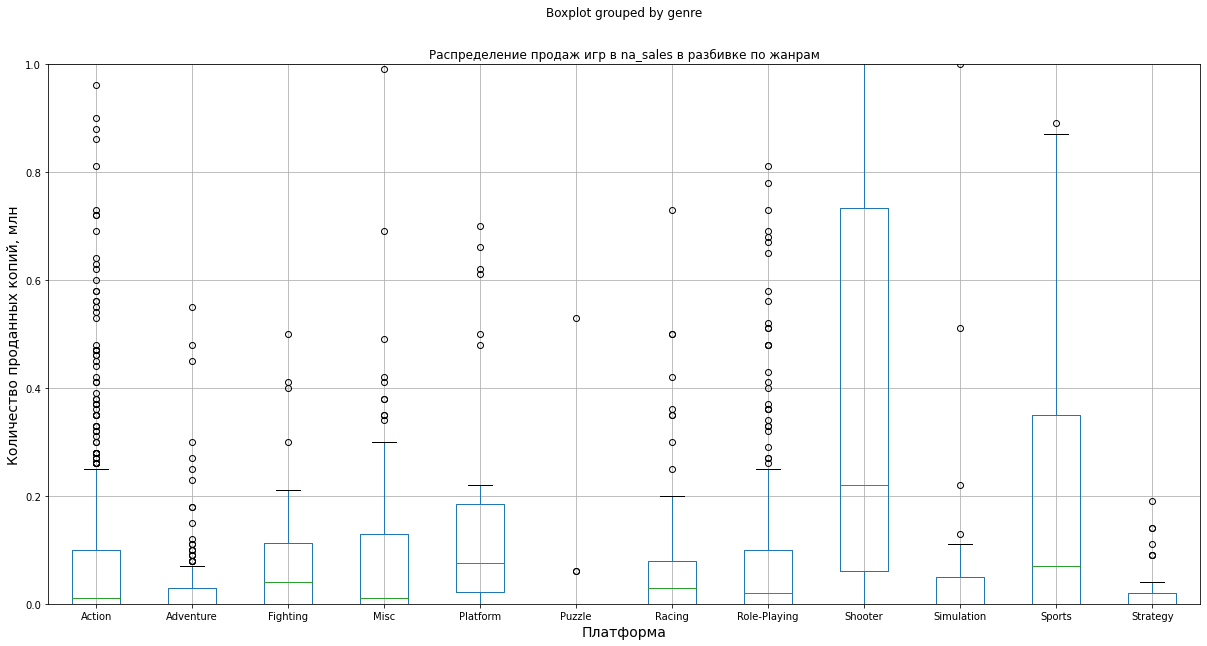

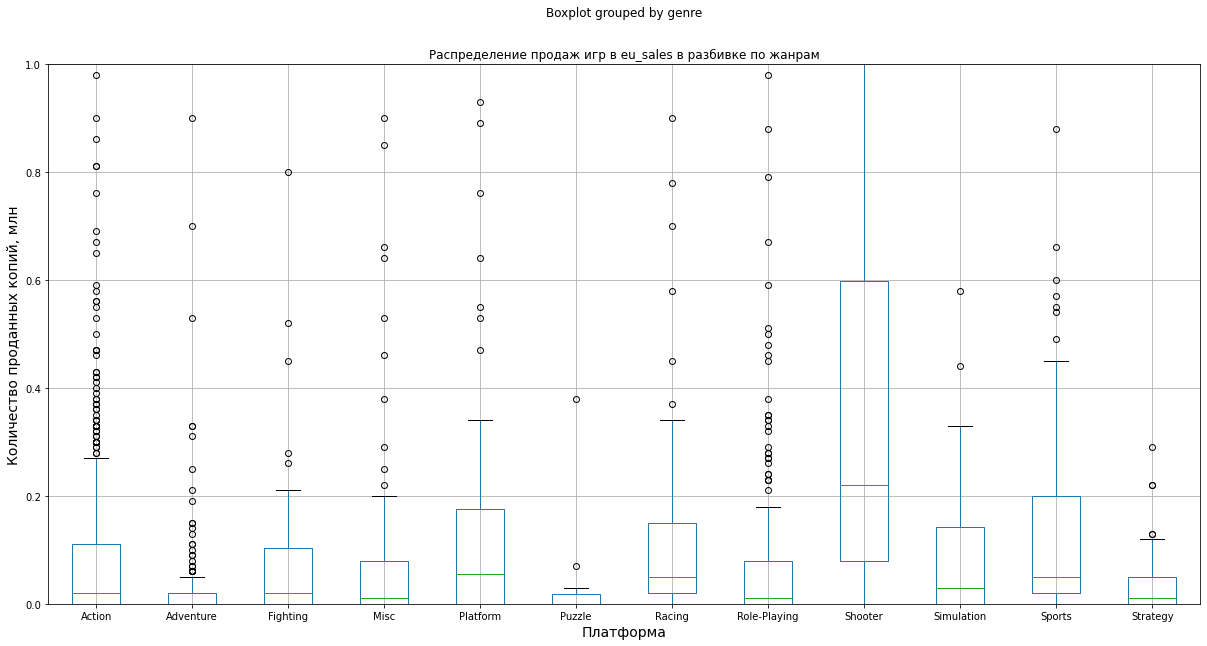

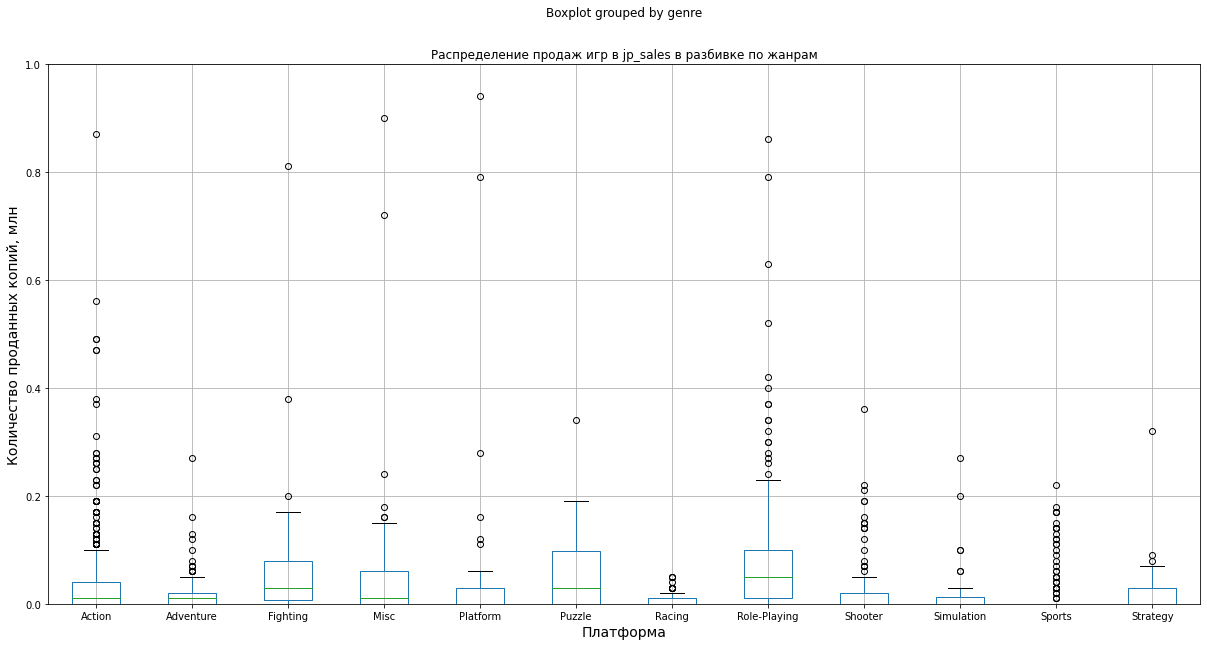

In [76]:
# создание списка регионов
columns = ['na_sales', 'eu_sales', 'jp_sales']
# oтображение диаграммы ящик с усами по глобальным продажам игр в Северной Америке, Европе, Японии в разбивке по жанрам
for item in columns:
    actual_data.boxplot(column=item, by='genre', figsize=(20,10))
    plt.ylim(0,1)
    plt.xlabel('Платформа', size=14)
    plt.ylabel('Количество проданных копий, млн', size=14)
    plt.title(f'Распределение продаж игр в {item} в разбивке по жанрам');

Самые популярные жанры игр для жителей в Северной Америке: shooter, sports, racing, fighting, action. Для пользователей в Европе топ-5 популярных жанров остается неизменным. Можно сделать вывод, что аудитория в Северной Америке и в Европе схожа в предпочтениях. На диаграммах видно, что количество проданных копий в Северной Америке значительно выше, чем в Европе. Совершенно иная картина распределения продаж по жанрам игр в Японии. Role-playing, puzzle, fighting - список лидирующих жанров в данной стране. Вероятно, это связано с культурными различиями. Также известно, что в Японии остро стоит проблема одиночества и ухода от реальности, а ролевые игры представляют возможность представить себя в роли какого-либо персонажа в разнообразных местах.

### Корреляция между рейтингом и продажами

Определим, влияет ли рейтинг ESRB на продажи в регионах. 

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «E» («everyone») — «для всех», «E10+» («everyone 10 and older») — «для всех от 10 лет и старше», «EC» («early childhood») — «для детей младшего возраста», «M» («mature») — «для взрослых», «T» («teen») — «подросткам», «RP» («rating pending») — «рейтинг ожидается».

В столбце 'rating' примерно 44% отсутствующих значений, поэтому, чтобы расммотреть, несут ли в себе важную информацию пропущенные значения в столбце 'rating', заменим отсутствующий возрастной рейтинг на 'Нет рейтинга'.

In [77]:
actual_data['rating'] = actual_data['rating'].fillna('Нет рейтинга')

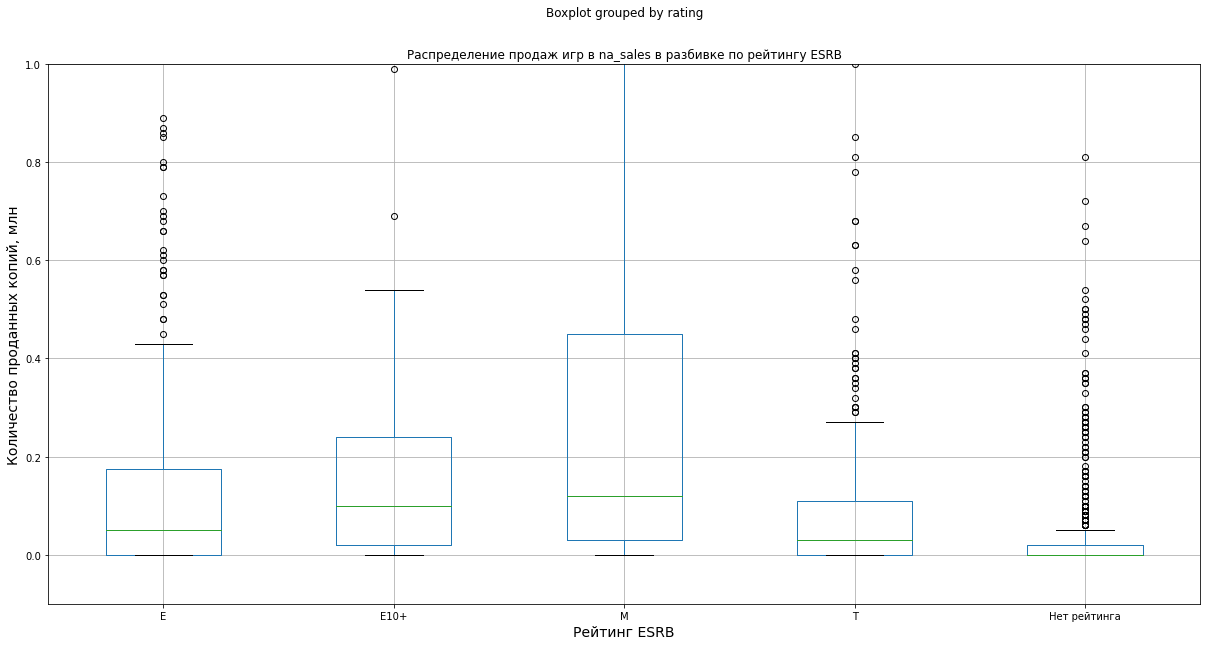

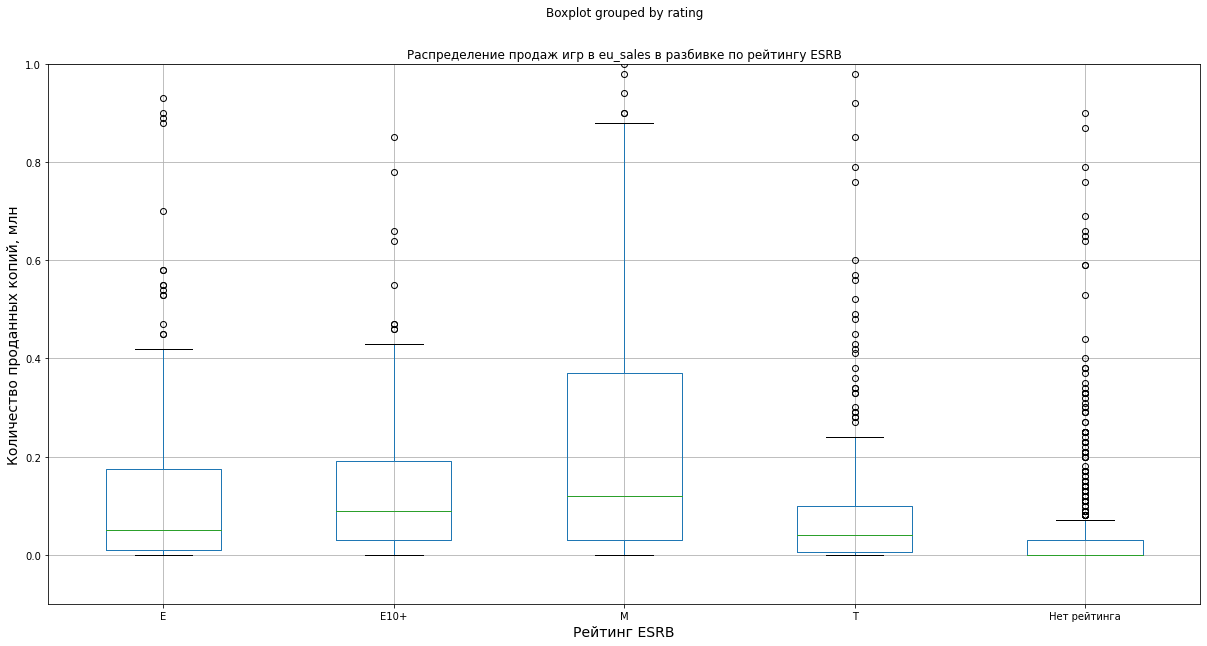

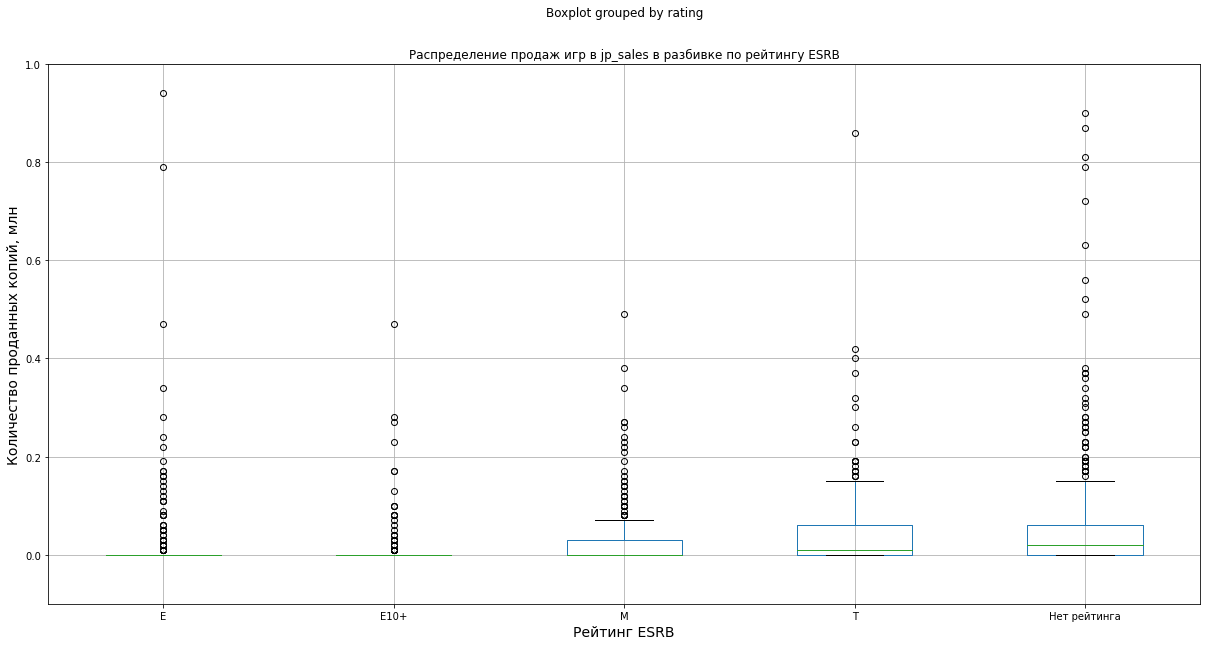

In [78]:
# создание списка регионов
columns = ['na_sales', 'eu_sales', 'jp_sales']
# oтображение диаграммы ящик с усами по глобальным продажам игр в Северной Америке, Европе, Японии в разбивке по рейтингу ESRB
for item in columns:
    actual_data.boxplot(column=item, by='rating', figsize=(20,10))
    plt.ylim(-0.1,1)
    plt.xlabel('Рейтинг ESRB', size=14)
    plt.ylabel('Количество проданных копий, млн', size=14)
    plt.title(f'Распределение продаж игр в {item} в разбивке по рейтингу ESRB');

В Северной Америке и в Европе наибольшее количество продаж у игр с возрастным рейтингом «для взрослых». Наибольшее количество проданных копии в Японии без рейтинга. Так как в Японии существуют жесткие правила по распространению игр с возрастными ограничениями, скорее под отсутствием рейтинга подразумевается продукт, который  пригоден для всех возрастов. Значит, самый популярный рейтинг игр в Японии «для всех». Вторая гипотеза возникновения большого количества пропусков в рейтинге - это неудачная склейка двух таблиц: продажи на Западе и на Востоке. Ассоциация, определяющая возрастной рейтинг компьютерных игр, на территории Северной Америки - ESRB, а на территории Японии аналогичная - CERO. Скорее всего, данные ассоциации не присваивают рейтинг уже маркированным видеоиграм.

**Вывод**

В Северной Америке и Европе наиболее популярны стационарные платформы, в Японии портативные платформы. Cамые популярные жанры игр для жителей в Северной Америке и Европе: shooter, sports, racing, а в Японии role-playing, puzzle, fighting. Рейтинг ESRB влияет на продаже в Северной Америке и в Европе(приобретают игры "для взрослых"), но не влияет на продажи в Японии. Аудитория в Северной Америке и в Европе схожа в предпочтениях в связи с схожим менталитетом.

## Проверка гипотез

Проверим две исследовательские гипотезы:
* средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [79]:
# выделим данные для платформы Xbox и PC отдельно в таблицы
actual_data_Xbox = actual_data.query('platform =="XOne"')
actual_data_PC = actual_data.query('platform =="PC"')
# при проверке гипотез необходимо удалить пропуски из столбца с пользовательскими оценками
actual_data_Xbox.dropna(subset = ['user_score'], inplace = True)
actual_data_PC.dropna(subset = ['user_score'], inplace = True)

In [80]:
# выделим данные для жанра Action и Sports отдельно в таблицы
actual_data_action = actual_data.query('genre =="Action"')
actual_data_sports = actual_data.query('genre =="Sports"')
# при проверке гипотез необходимо удалить пропуски из столбца с пользовательскими оценками
actual_data_action.dropna(subset = ['user_score'], inplace = True)
actual_data_sports.dropna(subset = ['user_score'], inplace = True)

In [81]:
# определение дисперсии выборок стат.тестом Левене
from scipy.stats import levene
[np.var(x, ddof=1) for x in [actual_data_Xbox['user_score'], actual_data_PC['user_score']]]

[1.8910066518846989, 2.9011543151334522]

In [82]:
# определение дисперсии выборок стат.тестом Левене
from scipy.stats import levene
[np.var(x, ddof=1) for x in [actual_data_action['user_score'], actual_data_sports['user_score']]]

[1.898476658476659, 3.4469791276090476]

Так как генеральные совокупности не зависят друг от друга, выборочные средние распределены нормально, значит можно использовать специальный метод stats.ttest_ind для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Выборки (средние пользовательские рейтинги платформ Xbox One и PC, средние пользовательские рейтинги жанров Action и Sports) примерно равного размера и дисперсии у совокупностей схожи, следовательно, параметр equal_var в методе примем True.

Для проверки исследовательской гипотезы, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, необходимо составить нулевую гипотезу и альтернативную. Альтернативная гипотеза - это утверждение, которое принимается верным, если отбрасывается нулевая гипотеза.

Нулевая гипотеза: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.

Альтернативная гипотеза: средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC.

In [83]:
# импорт библиотеки Scipy
from scipy import stats as st

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    actual_data_Xbox['user_score'], 
    actual_data_PC['user_score'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Итак, p-значение значительно выше установленного критического уровня статистической значимости, вероятность получить верные данные очень высока, гипотезу "средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC" не отвергаем, следовательно, уверенность в том, что гипотеза верна, повысилась.

Проверим исследовательскую гипотезу, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. 

Нулевая гипотеза: средний пользовательские рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

Альтернативная гипотеза: средний пользовательские рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

In [84]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    actual_data_action['user_score'], 
    actual_data_sports['user_score'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  2.8711147985105864e-19
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, так как экспериментальные данные очень маловероятны при условии, что гипотеза верна. Значит, средний пользовательские рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

## Вывод

Проанализированы данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах. В результате анализа имеем:
* В Северной Америке, Европе и Японии продажи по платформам отличаются
* Отзывы пользователей и критиков не влияют на продажи внутри одной популярной платформы 
* Самые высокие медианные продажи у игр жанра shooter, sports, fighting, racing, role-playing 
* Самые низкие продажи у игр жанра adventure, stategy
* В Северной Америке топ-5 популярных платформ: PS4, XOne, X360, 3DS, PS3
* В Европе топ-5 популярных платформ: PS4, XOne, PS3, PC, 3DS
* В Японии топ-5 популярных платформ: 3DS, PS4, PSV, PS3, WiiU
* В Северной Америке и Европе наиболее популярны стационарные платформы, в Японии портативные платформы
* Самые популярные жанры игр для жителей в Северной Америке и Европы: shooter, sports, racing, fighting, action
* Самые популярные жанры игр для жителей в Японии role-playing, puzzle, fighting
* Рейтинг ESRB влияет на продаже в Северной Америке и в Европе (приобретают игры "для взрослых")
* Рейтинг ESRB влияет на продажи в Японии (приобретают игры "для всех")

В ходе работы также были проверены две исследовательские гипотезы. Гипотеза "средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC" не была отвергнута, гипотеза "средний пользовательские рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports" была отвергнута и принята альтернативная "средний пользовательские рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports".